---
layout: article
title: cmos filter
author: spielhuus
tags: cmos,filter
category: article
logo: cmos_filter_files/cd4069.jpg
excerpt: this time i want to build filters with the cmos cd 4069. 
---


In [1]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'

import logging
logging.Logger.disabled=True

import matplotlib.pyplot as plt
import numpy as np

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython.display as ipd
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Plot.BodeDiagram import bode_diagram_gain

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()

In [2]:
class VoltageDivider1(SubCircuitFactory):
    __name__ = 'voltage_divider_1'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4):
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )

class VoltageDivider2(SubCircuitFactory):
    __name__ = 'voltage_divider_2'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4):
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )

class VoltageDivider3(SubCircuitFactory):
    __name__ = 'voltage_divider_3'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4):
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )


## low pass filter
{: class="is-subtitle is-size-2 is-lowercase is-italic"}

lets get started with the simplest filter, a low pass filter.  




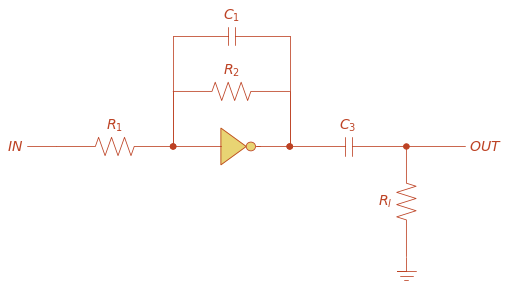

In [3]:
d = schemdraw.Drawing(inches_per_unit=0.6, color='#BD4224', lw=0.8, fill="#E8D473")

d.add(elm.Line('right', l=d.unit/4, lftlabel='$IN$'))
d.add(elm.Resistor('right', label='$R_1$'))
N1 = d.add(logic.Not)
C = d.add(elm.Capacitor(label='$C_3$'))
d.add(elm.Resistor("down",label='$R_l$'))
d.add(elm.Ground)

d.add(logic.Dot(xy=N1.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Resistor('right', label='$R_2$'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(logic.Dot(xy=N1.start))
d.add(elm.Line('up', l=d.unit))
d.add(elm.Capacitor('right', label='$C_1$'))
d.add(elm.Line('down', l=d.unit))
d.add(logic.Dot())

d.add(logic.Dot(xy=C.end))
d.add(elm.Line('right', l=d.unit/2, rgtlabel='$OUT$'))
#d.add(elm.Line('right', l=d.unit, rgtlabel='$OUT$'))

d.draw()

In [4]:
circuit = Circuit('cmos low pass filter')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2V SIN(0 2V 100)')

circuit.R(1, 'IN', 'gate_in_1', 100@u_kΩ)
#circuit.C('in1', 'r_in', 'gate_in_1', 47@u_nF)
circuit.X('1', '4069UB', 'gate_in_1', 'gate_out_1', '+5V', circuit.gnd)
circuit.R(2, 'gate_in_1', 'gate_out_1', 50@u_kΩ)
circuit.C(2, 'gate_in_1', 'gate_out_1', 10@u_nF)
#circuit.C(3, 'gate_out_1', 'OUT', 1@u_uF)
#circuit.R('load', 'OUT', circuit.gnd, 1@u_MOhm);

Capacitor C2

In [5]:
freq = 1 / (2 * np.pi * float(100@u_kΩ) * float(10@u_nF));
#print( freq )

for this filter we expect the cutoff frequency to be:

$$
\begin{array}{c}
f = \frac{1}{2 \pi RC} = \frac{1}{2 \pi 100k * 100n} = 159Hz
\end{array}
$$

In [6]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=10@u_kHz, number_of_points=10,  variation='dec')
analysis  = simulator.transient(step_time=1@u_us, start_time=10@u_ms, end_time=20@u_ms);

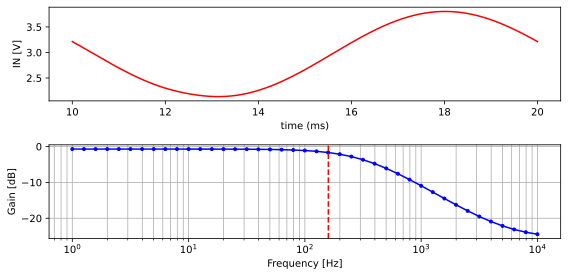

In [7]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8, 4))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
#ax1.plot(u_ms(analysis['OUT'].abscissa), analysis['OUT'], color='Red')
ax1.plot(u_ms(analysis['gate_out_1'].abscissa), analysis['gate_out_1'], color='Red')

bode_diagram_gain(axe=ax2,
                 frequency=analysis_ac.frequency,
                 gain=20*np.log10(np.absolute(analysis_ac['gate_out_1'])),
                 marker='.',
                 color='blue',
                 linestyle='-',
)
ax2.axvline(x=freq, color='Red', linestyle='--')

plt.tight_layout()
plt.show()

## resonant low pass filter
{: class="is-subtitle is-size-2 is-lowercase is-italic"}

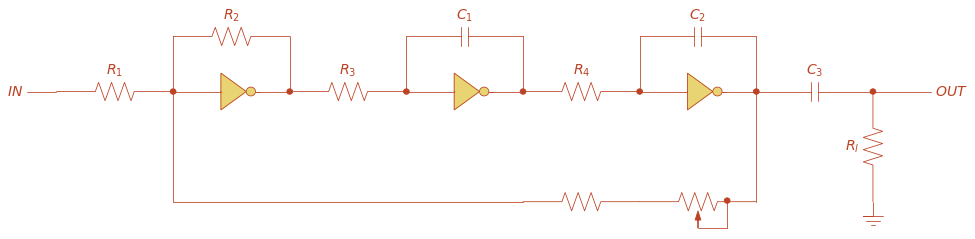

In [8]:
d = schemdraw.Drawing(inches_per_unit=0.6, color='#BD4224', lw=0.8, fill="#E8D473")

d.add(elm.Line('right', l=d.unit/4, lftlabel='$IN$'))
d.add(elm.Resistor('right', label='$R_1$'))
N1 = d.add(logic.Not)
d.add(elm.Resistor('right', label='$R_3$'))
N2 = d.add(logic.Not)
d.add(elm.Resistor('right', label='$R_4$'))
N3 = d.add(logic.Not)
C = d.add(elm.Capacitor(label='$C_3$'))
d.add(elm.Resistor("down",label='$R_l$'))
d.add(elm.Ground)

d.add(logic.Dot(xy=N1.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Resistor('right', label='$R_2$'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(logic.Dot(xy=N2.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Capacitor('right', label='$C_1$'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(logic.Dot(xy=N3.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Capacitor('right', label='$C_2$'))
d.add(elm.Line('down', l=d.unit/2))
D = d.add(logic.Dot())


d.add(elm.Line('down', l=d.unit, xy=D.start))
P = d.add(elm.Potentiometer('left'), label="$RV_1$")
d.add(elm.Resistor('left'), label="$R_5$")
d.add(elm.Line('left', l=3*d.unit))
d.add(elm.Line('up', l=d.unit))
d.add(elm.Line('right', l=d.unit/4, xy=P.tap))
d.add(elm.Line('up', l=d.unit/4))
d.add(logic.Dot())

d.add(logic.Dot(xy=C.end))
d.add(elm.Line('right', l=d.unit/2, rgtlabel='$OUT$'))
#d.add(elm.Line('right', l=d.unit, rgtlabel='$OUT$'))

d.draw()

In [9]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2.5V SIN(0 2.5V 100)')

circuit.R(1, 'IN', 'r_in', 100@u_kΩ)
circuit.C('in1', 'r_in', 'gate_in_1', 47@u_nF)
circuit.X('1', '4069UB', 'gate_in_1', 'gate_out_1', '+5V', circuit.gnd)
circuit.R(2, 'gate_in_1', 'gate_out_1', 100@u_kΩ)
circuit.R(3, 'gate_out_1', 'gate_in_2', 20@u_kΩ)
circuit.X('2', '4069UB', 'gate_in_2', 'gate_out_2', '+5V', circuit.gnd)
circuit.C(1, 'gate_in_2', 'gate_out_2', 100@u_nF)
circuit.R(4, 'gate_out_2', 'gate_in_3', 10@u_kΩ)
circuit.X('3', '4069UB', 'gate_in_3', 'gate_out_3', '+5V', circuit.gnd)
circuit.C(2, 'gate_in_3', 'gate_out_3', 100@u_nF)
circuit.C(3, 'gate_out_3', 'OUT', 100@u_nF)
circuit.R('load', 'OUT', circuit.gnd, 100@u_kΩ);

In [10]:
#buffer_data = []
#for r in np.arange(100@u_kΩ, 200@u_kΩ, 25@u_kΩ):
#    circuit.R2.resistance = r

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=100@u_Hz, number_of_points=10,  variation='dec')
analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=10@u_ms);
#buffer_data.append(np.array(analysis['OUT']));


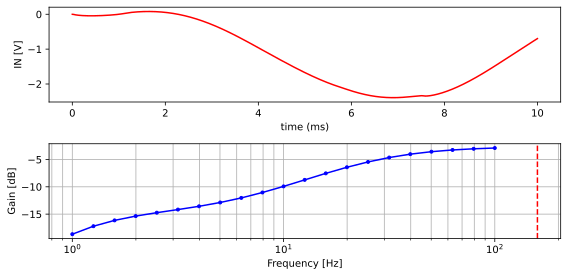

In [11]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8, 4))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
ax1.plot(u_ms(analysis['OUT'].abscissa), analysis['OUT'], color='Red')

bode_diagram_gain(axe=ax2,
                 frequency=analysis_ac.frequency,
                 gain=20*np.log10(np.absolute(analysis_ac['OUT'])),
                 marker='.',
                 color='blue',
                 linestyle='-',
)
ax2.axvline(x=freq, color='Red', linestyle='--')

plt.tight_layout()
plt.show()

## low pass filter
{: class="is-subtitle is-size-2 is-lowercase is-italic"}

In [13]:
circuit = Circuit('cmos low pass filter')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2 SIN(0 2V 100)')

circuit.X('1', '4069UB', 'gate_in', 'gate_out', '+5V', circuit.gnd)
circuit.R(2, 'gate_out', 'gate_in', 100@u_kΩ)
circuit.C(1, 'gate_out', 'gate_in', 100@u_nF)
circuit.R(1, 'gate_in', 'IN', 100@u_kΩ);

In [14]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=100@u_Hz, number_of_points=10,  variation='dec')
#TODO remove
analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=10@u_ms)
analysis_ac = simulator.ac(start_frequency=10@u_Hz, stop_frequency=500@u_Hz, number_of_points=10,  variation='dec')


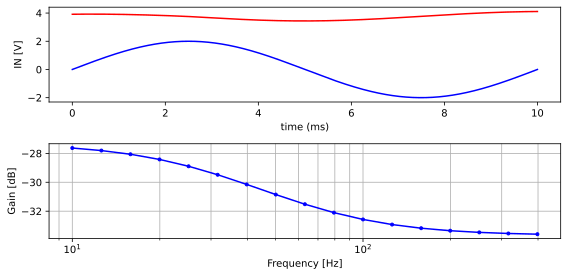

In [15]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8, 4))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
ax1.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Blue')
ax1.plot(u_ms(analysis['gate_out'].abscissa), analysis['gate_out'], color='Red')

bode_diagram_gain(axe=ax2,
                 frequency=analysis_ac.frequency,
                 gain=20*np.log10(np.absolute(analysis_ac['gate_out'])),
                 marker='.',
                 color='blue',
                 linestyle='-',
)

plt.tight_layout()
plt.show()

## low pass filter with resonance


%%itikz --temp-dir
\documentclass[border=1mm]{standalone}
\usepackage{circuitikz}
\usetikzlibrary{arrows,positioning}
\begin{document}
\begin{circuitikz}[auto, node distance=3cm]

\node [ieeestd not port](A1){\texttt{OA1}};
\draw (A1.out) to[R, l_=$R$,name=R1] ++(4.5,0);

\node [ieeestd not port,right of=R1](A2){\texttt{OA2}};
\draw (A2.out) to[R, l_=$R$,name=R2] ++(4,0);

\node [ieeestd not port,right of=R2](A3){\texttt{OA3}};
\draw (A3.out) to[R, l_=$R$] ++(4,0);

%\node[op amp] (U1) {$U_1$};
%\draw (U1.-) to[short] ++(1,0) to[R, l_=$R$,name=R1] ++(1,0);

%\node[op amp] (U2,right of=U1) {$U_2$};
%\draw (U2.-) to[short] ++(1,0) to[R, l_=$R$,name=R2] ++(1,0);

%\node[op amp] (U3,right of=U2) {$U_3$};
%\draw (U3.-) to[short] ++(1,0) to[R, l_=$R$,name=R3] ++(1,0);

\draw (A1.in) to[short] ++(0,1) coordinate(tmp) to[R, l_=$R_1$,name=R1] (tmp -| A1.out) to[short] (A1.out);

\draw (A2.in) to[short] ++(0,1) coordinate(tmp) to[C, l_=$C_3$,name=R3] (tmp -| A2.out) to[short] (A2.out);
\draw (A3.in) to[short] ++(0,1) coordinate(tmp) to[C, l_=$C_3$,name=R4] (tmp -| A3.out) to[short] (A3.out);

%\node[xor port,right of=U1, anchor=in 2] (U2) {};
%    \draw[red] (U1.out) -| (U2.in 2);






\end{circuitikz}
\end{document}


$$
\begin{array}{c}
f = \frac{1}{2 \pi RC}
\end{array}
$$

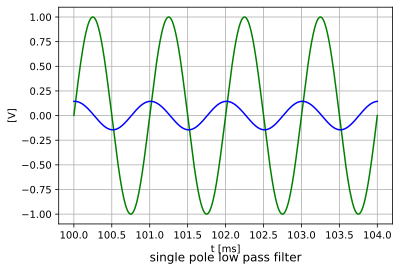

In [16]:
#load single pole low pass filter
kicad_netlist_path = directory_path.joinpath('single pole low pass filter/single pole low pass filter.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

lpf_circuit = parser.build_circuit(ground=5)
lpf_circuit.include(spice_library['4069UB'])
lpf_circuit.V('1', '+5V', lpf_circuit.gnd, 'DC 5')
lpf_circuit.V('3', 'IN', lpf_circuit.gnd, 'DC 0V AC 1V SIN(0 1 1k)')

simulator = lpf_circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac_lpf = simulator.ac(start_frequency=10@u_Hz, stop_frequency=500@u_Hz, number_of_points=10,  variation='dec')
analysis_lpf = simulator.transient(step_time=1@u_us, start_time=100@u_ms, end_time=104@u_ms)

fig, axis = plt.subplots(figsize=(6, 4))
axis.plot(u_ms(analysis_lpf['IN'].abscissa), analysis_lpf['IN'], c='Green')
axis.plot(u_ms(analysis_lpf['OUT'].abscissa), analysis_lpf['OUT'], c='Blue')

axis.grid()
axis.set_xlabel('t [ms]')
axis.set_ylabel('[V]')
axis.set_title('single pole low pass filter', y=-0.2)

plt.show()

In [17]:
#r1 = 100@u_kΩ
#c1 = 0.01@u_uF

#cutoff_frequency = solve(Eq(fc, lp_f.subs(R, r1).subs(C, c1).subs(pi,math.pi)))
#Eq(fc, lp_f.subs(R, r1).subs(C, c1).subs(pi,math.pi))


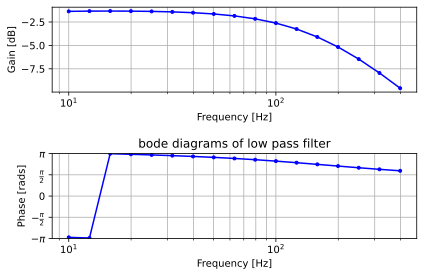

In [18]:
figure, axes = plt.subplots(2, figsize=(6, 4))
plt.title("bode diagrams of low pass filter")
#out = 'Net-_C1-Pad1_'
bode_diagram(axes=axes,
                 frequency=analysis_ac_lpf.frequency,
                 gain=20*np.log10(np.absolute(analysis_ac_lpf['OUT'])),
                 phase=np.angle(analysis_ac_lpf['OUT'], deg=False),
                 marker='.',
                 color='blue',
                 linestyle='-',
    )
#axes[0].axvline(x=cutoff_frequency, color='Red', linestyle='--')
plt.tight_layout()
plt.show()


## low pass filter with resonance


In [19]:
#load resonant low pass filter
kicad_netlist_path = directory_path.joinpath('low pass filter resonance/low pass filter resonance.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

lpf_res_circuit = parser.build_circuit(ground=5)
lpf_res_circuit.include(spice_library['4069UB'])
lpf_res_circuit.V('1', '+5V', lpf_res_circuit.gnd, 'DC 5')
lpf_res_circuit.V('2', 'IN', lpf_res_circuit.gnd, 'DC 0V AC 1V SIN(0 1V 1k)')

#for subcircuit in ( VoltageDivider1(R=100@u_kΩ,w=0.5)):
lpf_res_circuit.subcircuit(VoltageDivider1(R=100@u_kΩ,w=0.5))

simulator = lpf_res_circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac_lpf_res = simulator.ac(start_frequency=10@u_Hz, stop_frequency=500@u_Hz, number_of_points=10,  variation='dec')
analysis_lpf_res = simulator.transient(step_time=1@u_us, start_time=100@u_ms, end_time=104@u_ms)


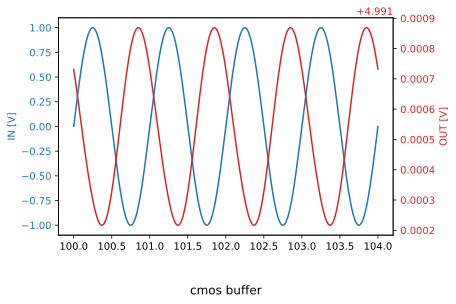

In [20]:
fig, ax1 = plt.subplots(figsize=(6, 4))

ax1.set_title('cmos buffer', y=-0.3)

color = 'tab:blue'
ax1.set_ylabel('IN [V]', color=color)
ax1.plot(u_ms(analysis_lpf_res['IN'].abscissa), analysis_lpf_res['IN'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_xlabel('time (ms)')
ax2.set_ylabel('OUT [V]', color=color)
ax2.plot(u_ms(analysis_lpf_res['OUT'].abscissa), analysis_lpf_res['OUT'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

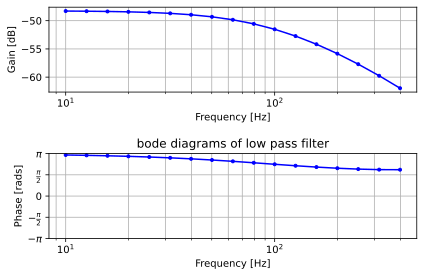

In [21]:
figure, axes = plt.subplots(2, figsize=(6, 4))
plt.title("bode diagrams of low pass filter")
#out = 'Net-_C1-Pad1_'
bode_diagram(axes=axes,
                 frequency=analysis_ac_lpf_res.frequency,
                 gain=20*np.log10(np.absolute(analysis_ac_lpf_res['OUT'])),
                 phase=np.angle(analysis_ac_lpf_res['OUT'], deg=False),
                 marker='.',
                 color='blue',
                 linestyle='-',
    )
#axes[0].axvline(x=cutoff_frequency, color='Red', linestyle='--')
plt.tight_layout()
plt.show()

## band pass filter



In [22]:
#load resonant band pass filter
kicad_netlist_path = directory_path.joinpath('band pass filter/band pass filter.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

bpf_res_circuit = parser.build_circuit(ground=5)
bpf_res_circuit.include(spice_library['4069UB'])
bpf_res_circuit.V('1', '+5V', bpf_res_circuit.gnd, 'DC 5')
bpf_res_circuit.V('2', 'IN', bpf_res_circuit.gnd, 'DC 0V AC 1V SIN(0 1V 1k)')

#for subcircuit in ( VoltageDivider1(R=100@u_kΩ,w=0.5)):
#lpf_res_circuit.subcircuit(VoltageDivider1(R=100@u_kΩ,w=0.5))

simulator = bpf_res_circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac_bpf = simulator.ac(start_frequency=10@u_Hz, stop_frequency=500@u_Hz, number_of_points=10,  variation='dec')
analysis_bpf = simulator.transient(step_time=1@u_us, start_time=100@u_ms, end_time=104@u_ms)


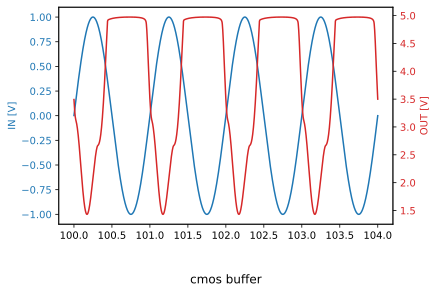

In [23]:
fig, ax1 = plt.subplots(figsize=(6, 4))

ax1.set_title('cmos buffer', y=-0.3)

color = 'tab:blue'
ax1.set_ylabel('IN [V]', color=color)
ax1.plot(u_ms(analysis_bpf['IN'].abscissa), analysis_bpf['IN'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_xlabel('time (ms)')
ax2.set_ylabel('OUT [V]', color=color)
ax2.plot(u_ms(analysis_bpf['OUT'].abscissa), analysis_bpf['OUT'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

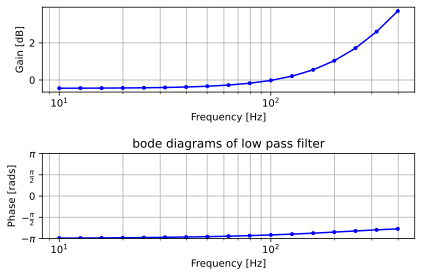

In [24]:
figure, axes = plt.subplots(2, figsize=(6, 4))
plt.title("bode diagrams of low pass filter")
#out = 'Net-_C1-Pad1_'
bode_diagram(axes=axes,
                 frequency=analysis_ac_bpf.frequency,
                 gain=20*np.log10(np.absolute(analysis_ac_bpf['OUT'])),
                 phase=np.angle(analysis_ac_bpf['OUT'], deg=False),
                 marker='.',
                 color='blue',
                 linestyle='-',
    )
#axes[0].axvline(x=cutoff_frequency, color='Red', linestyle='--')
plt.tight_layout()
plt.show()

## state variable filter

![state variable filter](state variable filter.svg)

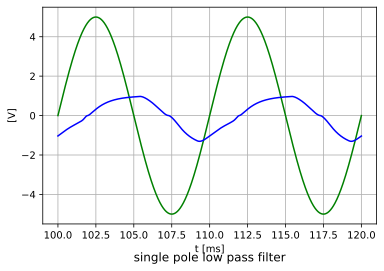

In [25]:
#load single pole low pass filter
kicad_netlist_path = directory_path.joinpath('state variable filter/state variable filter.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

svf_circuit = parser.build_circuit(ground=5)
svf_circuit.include(spice_library['4069UB'])
svf_circuit.V('1', '+5V', svf_circuit.gnd, 'DC 5')
svf_circuit.V('2', 'IN', svf_circuit.gnd, 'DC 0V AC 5V SIN(0 5 100)')

for subcircuit in ( VoltageDivider1(R=100@u_kΩ,w=0.5), 
                    VoltageDivider2(R=100@u_kΩ,w=0.1), 
                    VoltageDivider3(R=100@u_kΩ,w=0.1)):
    svf_circuit.subcircuit(subcircuit)

simulator = svf_circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac_svf = simulator.ac(start_frequency=10@u_Hz, stop_frequency=100@u_kHz, number_of_points=10,  variation='dec')
analysis_svf = simulator.transient(step_time=1@u_us, start_time=100@u_ms, end_time=120@u_ms)

fig, axis = plt.subplots(figsize=(6, 4))
axis.plot(u_ms(analysis_svf['IN'].abscissa), analysis_svf['IN'], c='Green')
axis.plot(u_ms(analysis_svf['OUT'].abscissa), analysis_svf['OUT'], c='Blue')

axis.grid()
axis.set_xlabel('t [ms]')
axis.set_ylabel('[V]')
axis.set_title('single pole low pass filter', y=-0.2)

plt.show()

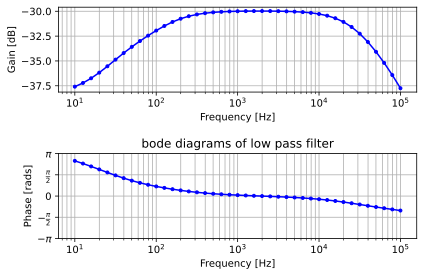

In [26]:
figure, axes = plt.subplots(2, figsize=(6, 4))
plt.title("bode diagrams of low pass filter")
#out = 'Net-_C1-Pad1_'
bode_diagram(axes=axes,
                 frequency=analysis_ac_svf.frequency,
                 gain=20*np.log10(np.absolute(analysis_ac_svf['OUT'])),
                 phase=np.angle(analysis_ac_svf['OUT'], deg=False),
                 marker='.',
                 color='blue',
                 linestyle='-',
    )
#axes[0].axvline(x=cutoff_frequency, color='Red', linestyle='--')
plt.tight_layout()
plt.show()

## *references*

- [CD4069](https://www.ti.com/lit/ds/schs054e/schs054e.pdf) datasheet
- [LOGIC NOISE](https://hackaday.com/2015/03/25/logic-noise-filters-and-drums/) filters and drums by Elliot Williams